In [16]:
import string
import re

import nltk
import gensim
import warnings
import pyLDAvis.gensim

import pandas as pd

from nltk.tokenize import PunktSentenceTokenizer
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.tokenize import sent_tokenize
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
from gensim.models import CoherenceModel
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

# Load Text of Book

In [2]:
fname="/home/ghavimbm/notebook/test/data/book/War_and_Peace_Book_One.txt"
with open(fname) as f:
    content = f.readlines()

# Data Preprocessing

In [3]:
if "About this digital edition\n" in content:
    content=content[:content.index("About this digital edition\n")]
if "CHAPTER I\n" in content:
    content=content[content.index("CHAPTER I\n"):]   
content=list(filter(lambda a: a != '\n', content))
text = " ".join(content).lower()
text, _ = re.subn('\s+', ' ', text)
text = text.strip()

In [4]:
sentences = sent_tokenize(text, language = "english")

In [5]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'may', 'also', 'across','among', 'beside', 'however', 'yet', 'within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

In [6]:
def preprocess_text(sentences):
    ls_items=[]
    for item in sentences:
        text = removeStopWords(item.translate(str.maketrans('','',string.punctuation)))
        text, _ = re.subn('\s+', ' ', text)
        text=lemmatizing(text)
        ls_items.append(text.split(" "))
    return ls_items

In [7]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizing(sentence):
    lemmSentence = ""
    for word in sentence.split():
        lemm = wordnet_lemmatizer.lemmatize(word, 'v')
        lemmSentence += lemm
        lemmSentence += " "
    lemmSentence = lemmSentence.strip()
    return lemmSentence

In [8]:
clean_sentences=preprocess_text(sentences)

# Make Dictionary out of Text

In [9]:
dictionary = corpora.Dictionary(clean_sentences)
corpus = [dictionary.doc2bow(text) for text in clean_sentences]

# Decide For number of Topics

In [10]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
    for NUM_TOPICS in tqdm(range(start, limit, step)):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics = NUM_TOPICS, distributed=False, passes=15, alpha='auto', eta='auto', iterations=100, random_state=45, callbacks=[perplexity_logger])
        model_list.append(ldamodel)
        coherencemodel = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [11]:
model_list, coherence_values = compute_coherence_values(dictionary, corpus, clean_sentences, start=2, limit=130, step=10)

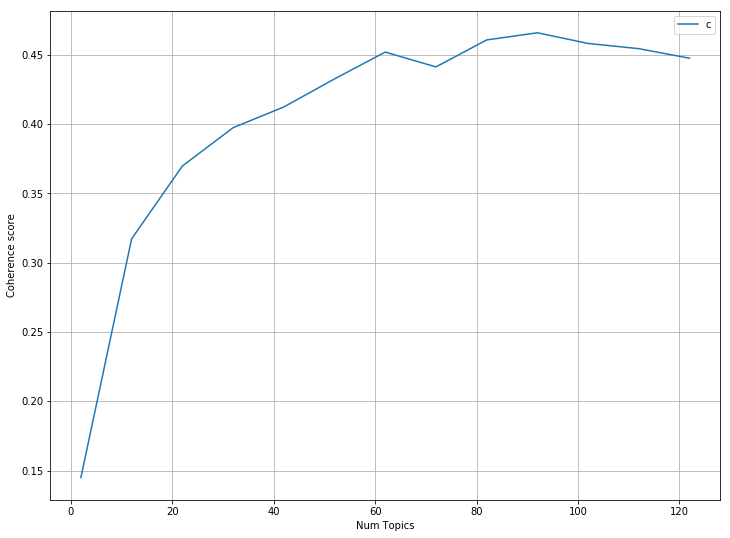

In [13]:
%matplotlib inline
limit=130; start=2; step=10;
x = range(start, limit, step)
plt.rcParams["figure.figsize"] = (12, 9)
plt.grid(True)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
model_list2, coherence_values2 = compute_coherence_values(dictionary, corpus, clean_sentences, start=2, limit=20,step=1)

In [30]:
lda_display = pyLDAvis.gensim.prepare(model_list2[8], corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [33]:
#10 topics is picked to have more seprated groups of topics
# but 90 topic gives better coherence score

In [31]:
NUM_TOPICS = 10
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics = NUM_TOPICS, distributed=False, passes=15, alpha='auto', eta='auto', iterations=100, random_state=45, callbacks=[perplexity_logger])

In [34]:
coherencemodel = CoherenceModel(model=ldamodel, texts=clean_sentences, dictionary=dictionary, coherence='c_v')

In [35]:
coherencemodel.get_coherence()

0.2866832880813666

# Select lable for each topic

In [116]:
num_topics = 10


topic_words = []
for i in range(num_topics):
    tt = ldamodel.get_topic_terms(i,9)
    topic_words.append([dictionary[pair[0]] for pair in tt])

In [139]:
topic_label=[]
for idx,item in enumerate(topic_words):
    topic_label.append(("-".join(item),idx))

In [140]:
ls_map_topic_sent_df=pd.DataFrame(topic_label)

In [144]:
ls_map_topic_sent_df.columns=["class_label","topic"]

# apply topic perdiction on each sentence

In [146]:
def topic_perdicter(clean_sentences):
    new_doc_bow = dictionary.doc2bow(clean_sentences)
    df_perdict=pd.DataFrame(ldamodel.get_document_topics(new_doc_bow))
    df_perdict.sort_values(1,inplace=True,ascending=False)
    return list(ls_map_topic_sent_df[ls_map_topic_sent_df["topic"]==list(df_perdict.head(1)[0])[0]][["topic","class_label"]].apply(lambda x: (x["topic"],x["class_label"]), axis=1))[0]

In [155]:
ls_perdicts=[]
for i in range(0,len(clean_sentences)):
    temp=[]
    temp.append(sentences[i])
    temp.append(clean_sentences[i])
    perdict=topic_perdicter(clean_sentences[i])
    temp.append(perdict[0])
    temp.append(perdict[1])
    ls_perdicts.append(temp)

In [156]:
td=pd.DataFrame(ls_perdicts)

In [164]:
td.to_csv("./Data/topic_modeling.csv", index=None)

# graph of the disturbution of sentences in each topic

In [158]:
td.columns=["sentences","sent_tokens","topic","label_topic"]

In [159]:
groups =td.groupby("topic")

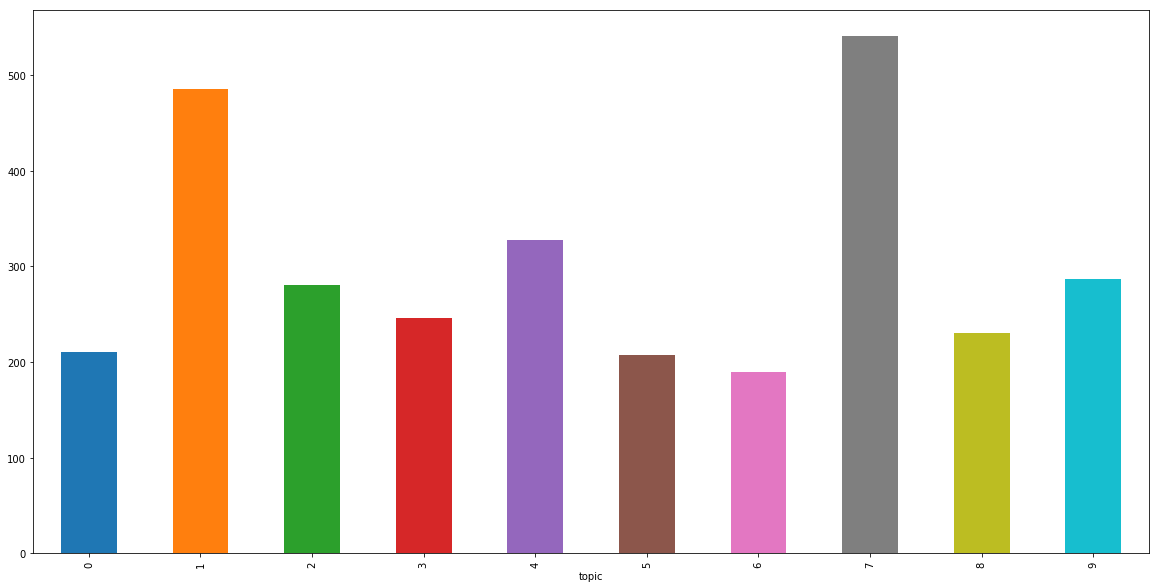

In [161]:
groups.describe()["label_topic"]["count"].plot(kind="bar",figsize=(20,10))

# label of each topic

In [162]:
ls_map_topic_sent_df.to_csv("./Data/topic_labels.csv",index=None)

,class_label,topic
0,say-prince-nothing-pierre-look-please-smile-kn...,0
1,count-go-pierre-prince-come-know-look-well-let,1
2,know-letter-father-man-pierre-see-princess-sil...,2
3,room-pierre-prince-draw-look-say-laugh-princes...,3
4,dont-say-know-ah-tell-be-dear-do-michael,4
5,princess-mary-say-give-prince-look-dinner-man-...,5
6,princess-say-mademoiselle-bourienne-always-cry...,6
7,say-prince-go-andrew-look-come-count-room-pierre,7
8,prince-hand-know-say-hold-princess-book-leave-...,8
9,anna-mikhaylovna-princess-prince-say-pierre-fa...,9
